### _Keras-Tensoflow implementtation of video classification using ConvLSTM_
Author : @leopauly | cnlp@leeds.ac.uk

In [1]:
##Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt

##Custom scripts
import lscript as lsp
import dataset as dset

Using TensorFlow backend.


In [2]:
## Defining variables
time_step=50 # Number of frames to be skipped
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
batch_size=2
LOG_DIR='./logdir'
custom_global_step=0
hidden_num = 24 # Number of neurons in hidden layer of LSTM
nb_classes=3
lr_rate=.0005
batch_size = 20
nb_seq_train=360
no_of_batches = int(nb_seq_train / batch_size)
epoch = 5
height=150
width=300
channel=1

True


#### Loading and displaying data

label:1.0
Video_seq shape: (20, 50, 150, 300) Label shape (20,)


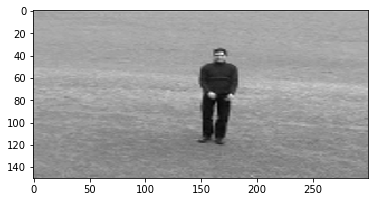

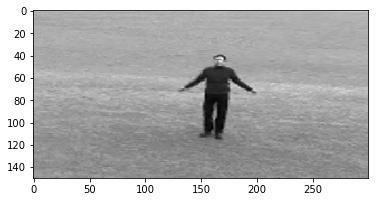

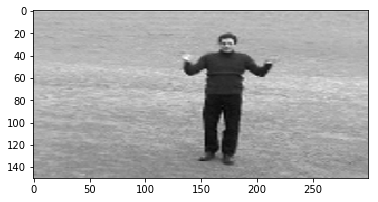

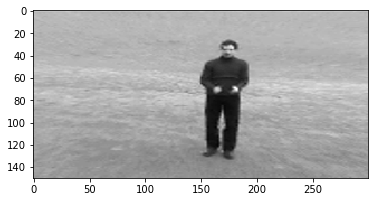

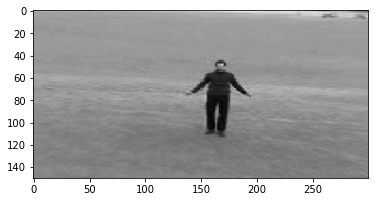

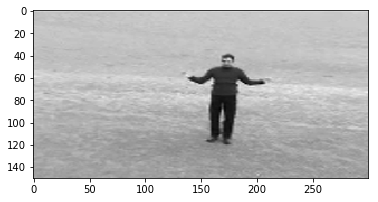

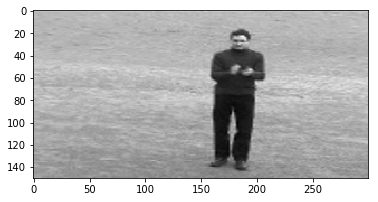

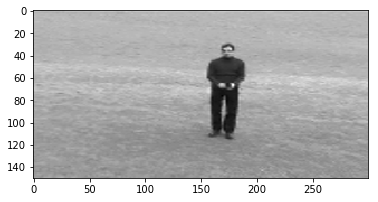

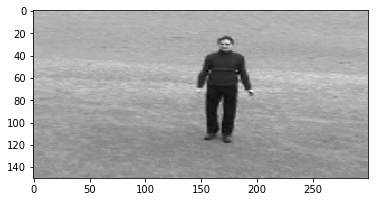

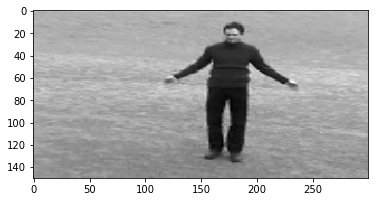

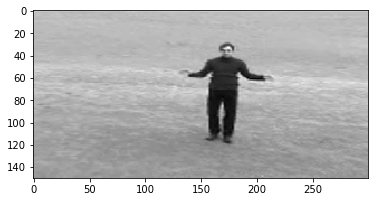

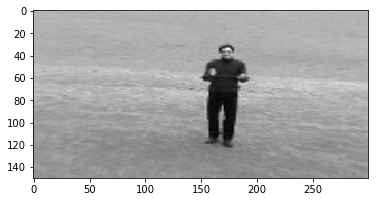

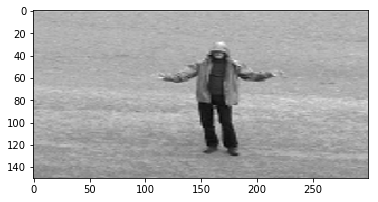

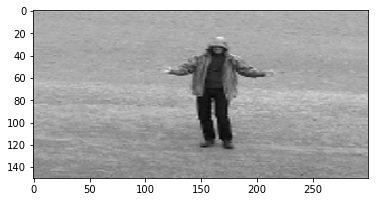

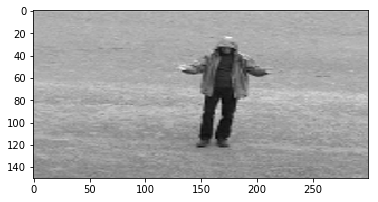

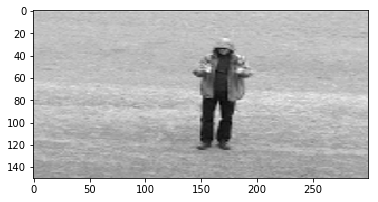

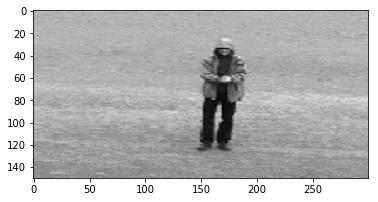

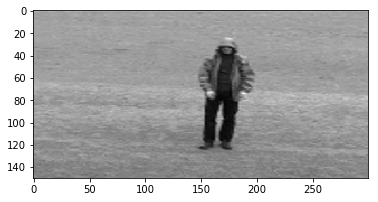

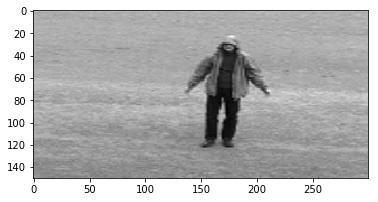

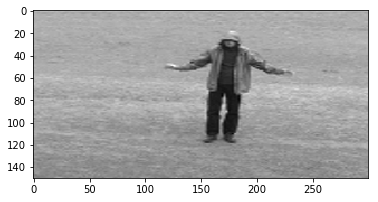

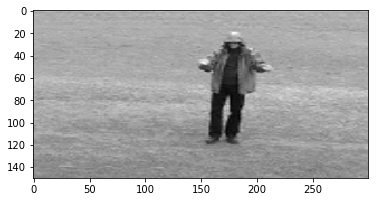

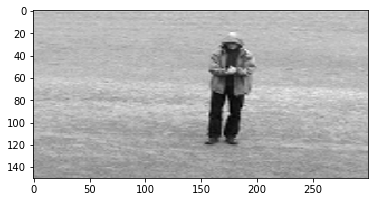

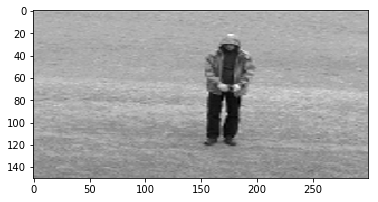

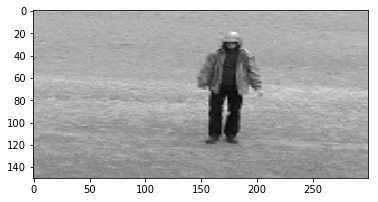

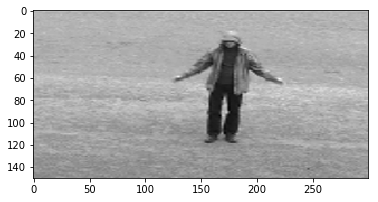

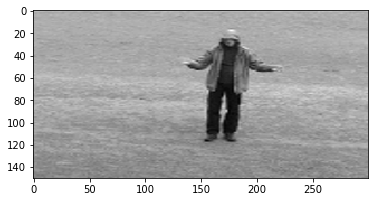

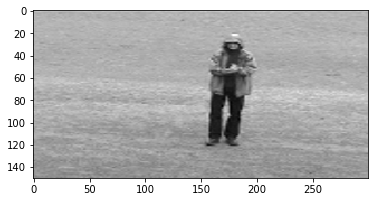

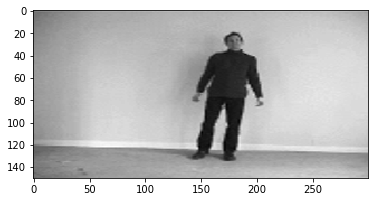

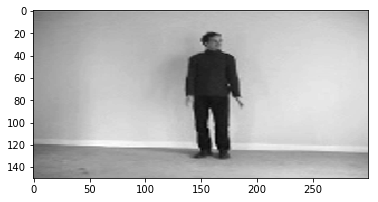

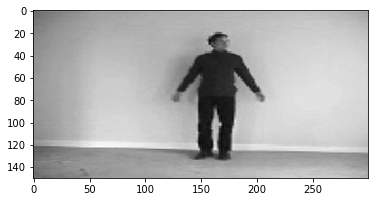

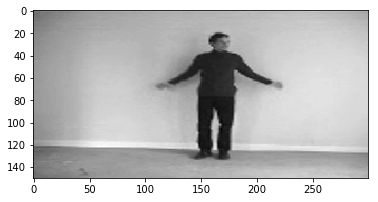

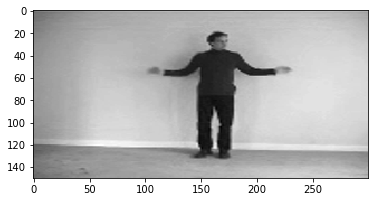

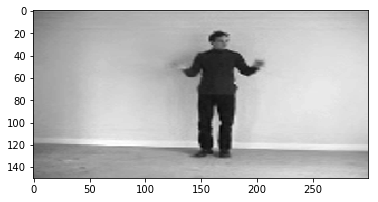

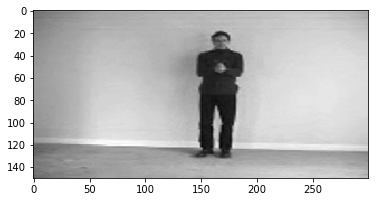

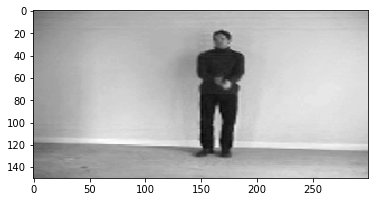

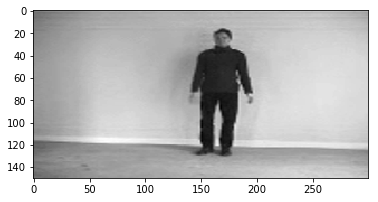

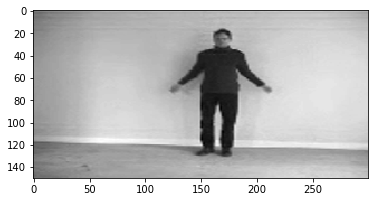

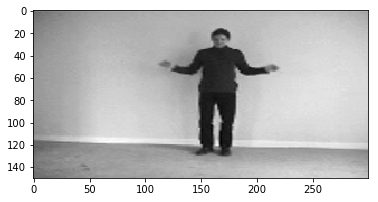

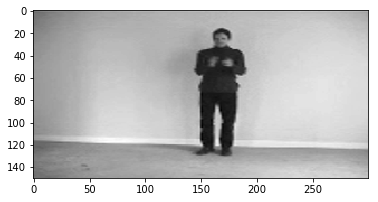

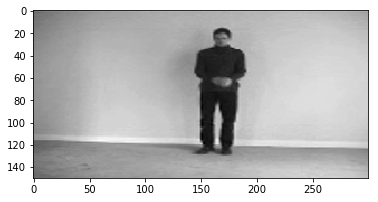

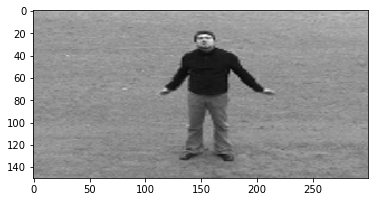

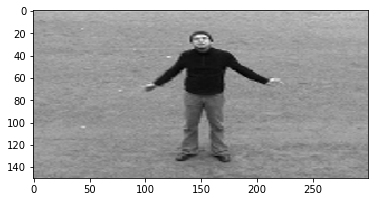

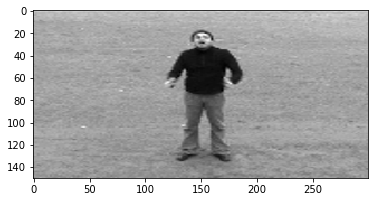

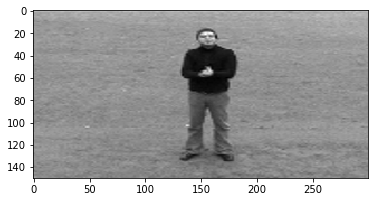

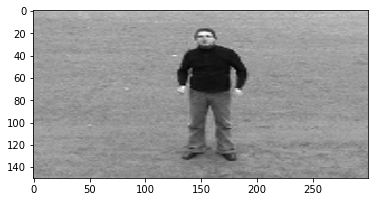

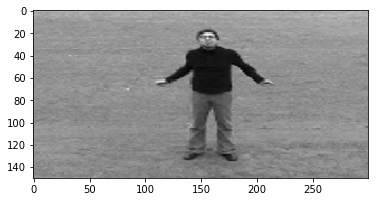

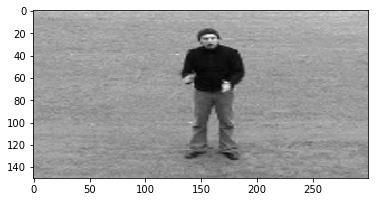

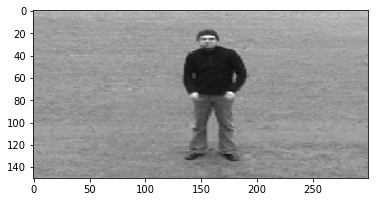

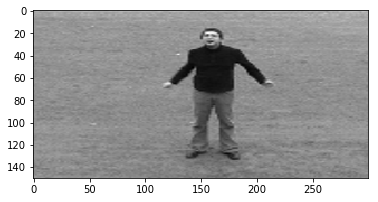

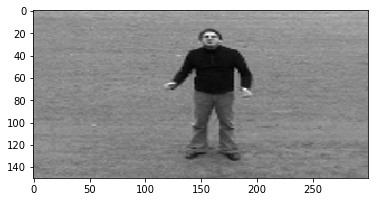

In [3]:
# TODO: Make display like an animation
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
item_num=19
lsp.view_video_seq(x,y,time_step,item_num)

#### Defining model

In [4]:
## Defining placeholders in tf
data = tf.placeholder(tf.float32, [None, time_step, height, width, channel]) #step_size=No: of frames in video sequence
target = tf.placeholder(tf.float32, [None, nb_classes])

In [5]:
## [1] Defining the model in keras using functional layers
input_ = Input(shape=(None, height, width, channel))
layer1=ConvLSTM2D(filters=1, kernel_size=(3, 3),padding='same', return_sequences=False)(input_)
model=Model(input_,layer1)
inter_out=model(data)
print(model.summary())

layer2=tf.nn.max_pool(inter_out,ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')
layer3=tf.contrib.layers.flatten(layer2)
out=tf.layers.dense(layer3,nb_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 150, 300, 1) 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 150, 300, 1)       76        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
predictions= tf.nn.softmax(out)
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=out))
optimizer = tf.train.AdamOptimizer(lr_rate)
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(predictions, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

# Defining variables for writing summary
tf.summary.histogram("predictions",predictions )
tf.summary.scalar("cross_entropy",cross_entropy )
summary_op = tf.summary.merge_all()

#### Training model

In [7]:
#TODO : make data generater to generate class also
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

saver = tf.train.Saver()
train_writer = tf.summary.FileWriter('./logdir', sess.graph)

for i in range(epoch):
    ptr = 0
    for iteration in range(no_of_batches):
        #x=dset.batch_gen(0+(batch_size*iteration),batch_size+(batch_size*iteration),batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
        y_onehot = lsp.one_hot(y,nb_classes)
        #print(x.shape,y.shape)
        
        summ_string,_=sess.run([summary_op,minimize],{data: x, target: y_onehot})
        train_writer.add_summary(summ_string,custom_global_step+1) # Writing summary to disc
        custom_global_step+=1
        
        print('Iteration {}'.format(iteration))
    print ('Epoch {}'.format(str(i)))

saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Epoch 0
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Epoch 1
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Epoch 2
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Epoch 3
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


'./logdir/model.ckpt'

#### Visualising layers

(50, 150, 300, 1)
(1, 50, 150, 300, 1)
(1, 150, 300, 1)
(150, 300)


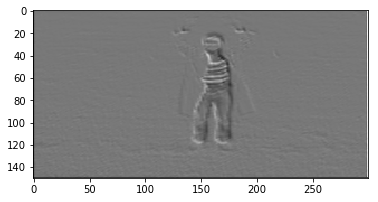

In [8]:
x,y=dset.batch_gen_test(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

img=x[12]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result6.png')
plt.show()

In [9]:
sess=tf.InteractiveSession() 
saved_model = tf.train.import_meta_graph('./logdir/model.ckpt.meta')
saved_model.restore(sess, tf.train.latest_checkpoint('./logdir'))

INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt


(50, 150, 300, 1)
(1, 50, 150, 300, 1)
(1, 150, 300, 1)
(150, 300)


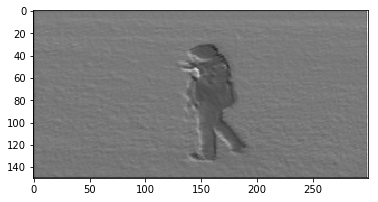

In [ ]:
img=x[1]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result3.png')
plt.show()

#### Tensorboard

In [ ]:
# Checking the items in the log directory
!tensorboard --inspect --logdir='./logdir/'

# Running tensorflow
print('If on windows system go to: http://localhost:6006')
!tensorboard --logdir='./logdir/'

Processing event files... (this can take a few minutes)

Found event files in:
./logdir/

These tags are in ./logdir/:
audio -
histograms
   predictions
images -
scalars
   cross_entropy
tensor -

Event statistics for ./logdir/:
audio -
graph
   first_step           0
   last_step            0
   max_step             0
   min_step             0
   num_steps            1
   outoforder_steps     []
histograms
   first_step           1
   last_step            85
   max_step             85
   min_step             1
   num_steps            85
   outoforder_steps     []
images -
scalars
   first_step           1
   last_step            85
   max_step             900
   min_step             1
   num_steps            900
   outoforder_steps     [(900, 1)]
sessionlog:checkpoint -
sessionlog:start -
sessionlog:stop -
tensor -

If on windows system go to: http://localhost:6006
Starting TensorBoard b'47' at http://0.0.0.0:6006
(Press CTRL+C to quit)


In [ ]:
sess.close()